In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()
    # .config("spark.executor.memory", "70g") \
    # .config("spark.driver.memory", "50g") \

sc = spark.sparkContext
# print('----',sc._conf.get('spark.driver.memory'))
# print('----',sc._conf)
# print('----',sc.getConf())
# print('----',sc.getConf().getAll())
# sc._conf.set('spark.executor.memory','20g').set('spark.driver.memory','20g').set('spark.driver.maxResultsSize','0')
# sc._conf.set('spark.executor.memory','20g').set('spark.driver.memory','20g')
# print(sc.getConf().get("spark.executor.instances"))
# sc = spark._jsc.sc() 
# n_workers =  len([executor.host() for executor in sc.statusTracker().getExecutorInfos() ]) -1
print('----',sc.getConf().getAll())

# print(n_workers)

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])
        # StructField("ORIGINE_CAR_KEY",StringType(),True), \
        # StructField("FINAL_CAR_KEY",StringType(),True), \

22/02/09 20:12:18 WARN Utils: Your hostname, jupyter resolves to a loopback address: 127.0.1.1; using 172.16.199.64 instead (on interface eth0)
22/02/09 20:12:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/09 20:12:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---- [('spark.sql.warehouse.dir', 'file:/home/user1/jupyter/MassiveDataAnalytics/project/spark-warehouse'), ('spark.executor.id', 'driver'), ('spark.driver.port', '34265'), ('spark.driver.host', '172.16.199.64'), ('spark.app.name', 'Spark_Processor'), ('spark.executor.memory', '64g'), ('spark.driver.memory', '64g'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.submit.deployMode', 'client'), ('spark.app.startTime', '1644437539985'), ('spark.app.id', 'local-1644437542837'), ('spark.ui.showConsoleProgress', 'true')]


In [2]:
# df = spark.read.csv('Sample_Traffic.csv',header=True,schema=schema)
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
# x = df.rdd.map(lambda x: x[0])
df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
|        155|       81|       87625017|     87625017|               5|       161|2021-06-01 04:14:21|
|     631757|       81|        8652928|      8652928|               5|       161|2021-06-01 03:58:57|
|     631757|       81|        8548123|      8548123|               5|       161|2021-06-01 04:01:38|
|     631757|       81|       24715264|     24715264|               5|       161|2021-06-01 03:56:57|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



# SVD

In [3]:
DATA_COUNT = df.count()
CAR_COUNT = df.select('FINAL_CAR_KEY').distinct().count()
CAMERA_COUNT = df.select('DEVICE_CODE').distinct().count()
print('all count: ', DATA_COUNT)
print('car count: ', CAR_COUNT)
print('camera count: ', CAMERA_COUNT)

all count:  34989160
car count:  5487645
camera count:  1035


In [3]:
car_counts = df.groupBy('FINAL_CAR_KEY', 'DEVICE_CODE').count()
car_counts.sort('count', ascending=False).show(20)
# car_counts = df.groupBy('FINAL_CAR_KEY').count()
# car_counts.sort('count', ascending=False).show(10)

+-------------+-----------+------+
|FINAL_CAR_KEY|DEVICE_CODE| count|
+-------------+-----------+------+
|     64111706|   22010039|101540|
|     64111706|   22010048| 74714|
|     64111706|   22010061| 73444|
|     64111706|   22010040| 51751|
|     64111706|   22010078| 49628|
|     64111706|   22010047| 43255|
|     64111706|   22010059| 39823|
|     64111706|   22010053| 39176|
|     64111706|   22010054| 38625|
|     64111706|   22010083| 34779|
|     64111706|   22010060| 33991|
|     64111706|   22010058| 31256|
|     64111706|     631640| 30567|
|     64111706|   22010079| 30521|
|     64111706|   22010080| 30356|
|     64111706|   22010088| 24077|
|     64111706|  100701119| 21319|
|     69177480|   22010061| 19105|
|     64111706|   22010094| 16564|
|     64111706|   22010087| 15686|
+-------------+-----------+------+
only showing top 20 rows



In [ ]:
# traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(103)[3:]
traffic_cars = car_counts.filter(car_counts['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(100)
traffic_cars = [x.FINAL_CAR_KEY for x in traffic_cars]
top_cars_df = df.filter(df.FINAL_CAR_KEY.isin(traffic_cars))
top_cars_df.show(5)

In [6]:
TOP_CARS_COUNT = top_cars_df.count()
TOP_CARS_COUNT

36907

In [7]:
camera_car_df = top_cars_df.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
camera_car_df.show(5)

+-----------+-------------+-----+
|DEVICE_CODE|FINAL_CAR_KEY|count|
+-----------+-------------+-----+
|     631367|      8642668|    6|
|     631357|     13565906|   16|
|     900249|     11054045|   14|
|     900237|     17890990|   21|
|     631829|     11054045|    6|
+-----------+-------------+-----+
only showing top 5 rows



In [9]:
from pyspark.ml.feature import StringIndexer

camera_car_indexed_df = StringIndexer(inputCol='FINAL_CAR_KEY', outputCol='CAR_INDEX').fit(camera_car_df).transform(camera_car_df)
camera_car_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='CAMERA_INDEX').fit(camera_car_indexed_df).transform(camera_car_indexed_df)

camera_car_indexed_df.show(5)
 

+-----------+-------------+-----+---------+------------+
|DEVICE_CODE|FINAL_CAR_KEY|count|CAR_INDEX|CAMERA_INDEX|
+-----------+-------------+-----+---------+------------+
|        135|     11086409|    1|      3.0|       139.0|
|     213301|     25826200|    1|      6.0|       226.0|
|        144|      8556436|    2|     40.0|        90.0|
|     202601|      8137760|    2|     37.0|        45.0|
|   22010087|      7633319|    7|      0.0|       234.0|
+-----------+-------------+-----+---------+------------+
only showing top 5 rows



In [10]:
camera_car_df.select('DEVICE_CODE').distinct().count()

331

In [11]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(camera_car_indexed_df.rdd.map(lambda x: (int(x['CAR_INDEX']), int(x['CAMERA_INDEX']), x['count']) ))

In [15]:
svd = utility_matrix.toRowMatrix().computeSVD(100, computeU=True)
print(svd.s)

22/02/06 08:58:56 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.


[505.0079430191521,448.4295807359056,234.00214006863334,179.1701725920204,164.08997913184254,128.8791269976936,89.96735321905756,85.39518265895747,81.27830846566535,73.68298955156429,71.16152478824884,63.00000000000001,54.67770373301821,50.08082000595019,46.65059215674066,40.75131283041665,39.49700737544456,38.81535112797081,37.883517887572744,37.477208085831876,36.48712513043299,34.10351087756282,32.95191581964757,31.668219074999598,29.382353059741757,28.007321050538476,27.81619066292238,27.173428229890284,25.9063839257756,25.51413614576888,24.916241572216165,24.226667981846077,24.030657094981326,23.365738603258077,19.73522502525707,18.44050839391655,17.983228407353685,17.882637049599147,17.512933811166867,16.650162052423365,16.219922944230152,15.917728847396386,15.32284427560125,14.385998218746812,13.55772093864274,12.77531198470423,12.033550152122068,11.946000054777999,11.341697289372854,11.021451077725494,10.16109555211842,9.735261830759898,9.507578905362777,9.188825793668242,8.823

22/02/06 08:59:06 WARN RowMatrix: Requested 100 singular values but only found 98 nonzeros.
22/02/06 08:59:06 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [13]:
print(utility_matrix.numCols())
print(utility_matrix.numRows())

331
100


In [ ]:
# rdd = df.rdd.map(lambda x: ((x['FINAL_CAR_KEY'], x['PASS_DAY_TIME'].date()),  x['DEVICE_CODE']))
# rdd.take(5)

# Clustering

In [22]:
# df.show(2)
df.summary().show()

+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|summary|         DEVICE_CODE|         SYSTEM_ID|     ORIGINE_CAR_KEY|      FINAL_CAR_KEY|  CHECK_STATUS_KEY|        COMPANY_ID|
+-------+--------------------+------------------+--------------------+-------------------+------------------+------------------+
|  count|            34989160|          34989160|            34989160|           34989159|          34989159|          34989160|
|   mean|2.2262293326161418E7|236.54757084765683|3.6067905310963854E7|3.702608833010948E7|5.2871780656402745|218.93599797765935|
| stddev| 3.741603259148462E7| 84.44216726147245|3.1140705482597664E7|3.076635128051584E7|0.6188797307503013| 63.36385080523604|
|    min|                 100|                81|           100000013|          100000013|                 1|                 0|
|    25%|              900107|               282|           9713210.0|          9839529.0|       

In [7]:
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
# row1 = spark.createDataFrame(df.take(2), schema)
# row2 = spark.createDataFrame([(1,2,3,4,5,6,datetime.datetime.now())], schema)
# appended = row1.union(row2)
# appended.show()
# appended.withColumn('weekday', dayofweek(appended.PASS_DAY_TIME)).show()


df_with_time_columns = df.withColumn('weekday', dayofweek(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.withColumn('hour', hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'weekday', 'hour')
df_with_time_columns.show(5)
#  df.withColumn('weekday', dayofweek(df.PASS_DAY_TIME)).select('weekday').distinct().count()



+-----------+-------------+-------+----+
|DEVICE_CODE|FINAL_CAR_KEY|weekday|hour|
+-----------+-------------+-------+----+
|     200501|     10477885|      3|   3|
|        155|     87625017|      3|   4|
|     631757|      8652928|      3|   3|
|     631757|      8548123|      3|   4|
|     631757|     24715264|      3|   3|
+-----------+-------------+-------+----+
only showing top 5 rows



In [8]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'weekday',
    'hour'
).count()
camera_daily_df.show(5)

+-----------+-------+----+-----+
|DEVICE_CODE|weekday|hour|count|
+-----------+-------+----+-----+
|     631763|      3|   1|  178|
|        125|      3|   0|    1|
|        169|      3|   6|  396|
|     631776|      3|   4|   15|
|     900222|      3|   0|  533|
+-----------+-------+----+-----+
only showing top 5 rows



In [9]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

+-----------+-------+----+-----+------+
|DEVICE_CODE|weekday|hour|count|camera|
+-----------+-------+----+-----+------+
|     631763|      3|   1|  178| 667.0|
|        125|      3|   0|    1| 600.0|
|        169|      3|   6|  396|  78.0|
|     631776|      3|   4|   15| 513.0|
|     900222|      3|   0|  533| 230.0|
+-----------+-------+----+-----+------+
only showing top 5 rows



In [ ]:
# from pyspark.mllib.linalg.distributed import CoordinateMatrix

# camera_traffic_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (
#     int(x['camera']), 
#     (x['weekday']-1)*24 + x['hour'],
#     x['count'] 
#     )))


# camera_traffic_matrix.toRowMatrix().rows.take(1)

# from pyspark.mllib.clustering import LDA

# lda_model = LDA.train(camera_traffic_matrix.toRowMatrix().rows.map(lambda x: 
# (1, x)
# ), k = 2)
# topics = lda_model.topicsMatrix()
# topics

In [10]:
def convert_to_vector(x):
    camera = x[0]
    daily_list = x[1]
    vector = [0]*24*7
    for y in daily_list:
        index = y[0]
        count = y[1]
        vector[index] = count

    return (camera, vector)



camera_vectors = camera_daily_df.rdd.map(lambda x: 
    (
    x['DEVICE_CODE'], 
    (
        (x['weekday']-1)*24 + x['hour'],
         x['count']
    )
    )
).groupByKey().mapValues(list).map(convert_to_vector)

camera_vectors.cache()
camera_vectors.take(5)

[(631776,
  [54,
   17,
   11,
   12,
   10,
   11,
   21,
   48,
   70,
   93,
   125,
   159,
   187,
   158,
   112,
   74,
   104,
   170,
   223,
   241,
   251,
   226,
   56,
   0,
   0,
   9,
   11,
   7,
   10,
   23,
   66,
   166,
   185,
   157,
   179,
   160,
   148,
   140,
   149,
   196,
   341,
   483,
   594,
   452,
   315,
   182,
   83,
   45,
   55,
   33,
   18,
   14,
   15,
   38,
   124,
   352,
   311,
   285,
   401,
   378,
   370,
   288,
   339,
   396,
   777,
   1127,
   1134,
   1024,
   647,
   465,
   155,
   94,
   23,
   19,
   6,
   12,
   6,
   30,
   64,
   167,
   141,
   151,
   189,
   194,
   165,
   146,
   173,
   189,
   333,
   489,
   564,
   467,
   348,
   238,
   87,
   57,
   28,
   23,
   11,
   7,
   12,
   17,
   44,
   101,
   125,
   133,
   165,
   148,
   232,
   380,
   281,
   143,
   152,
   101,
   243,
   232,
   223,
   233,
   92,
   67,
   56,
   34,
   18,
   25,
   16,
   13,
   24,
   43,
   70,
   97,
   127,
   

In [17]:
from pyspark.mllib.clustering import LDA
from pyspark.mllib.linalg import Vectors
cluster_count = 5
lda_model = LDA.train(camera_vectors.map(lambda x: [x[0], Vectors.dense(x[1])]), k = cluster_count)
topics = lda_model.topicsMatrix()
topics

array([[ 11090.91019724,   9764.26997568,  13151.93952669,
         14826.24836443,  16736.63193596],
       [  7158.89999318,   5477.69478097,   8142.39051539,
         11957.32326952,  11844.69144094],
       [  4322.21973057,   3318.64169407,   4719.78599584,
          6875.25507441,   6202.09750511],
       [  4302.53762946,   3252.04260991,   4632.68692058,
          6517.48999924,   6051.24284082],
       [  2916.98352621,   2591.95446565,   3415.35589154,
          4950.51519628,   4689.19092032],
       [  4670.3907073 ,   3755.18619115,   5944.32385963,
          5535.57125147,   7512.52799045],
       [ 11571.90352903,   9585.59422545,  13640.99346677,
          8729.81388737,  18417.69489138],
       [ 15355.50303927,  16439.92950564,  21320.47436462,
         13337.17056158,  25267.92252889],
       [ 19251.18219788,  16409.99356358,  24511.95577776,
         14444.83661159,  37833.0318492 ],
       [ 22676.69490979,  18891.18694107,  32261.55832091,
         19013.87910932

In [ ]:
import matplotlib.pyplot as plt
print("Learned topics (as distributions over vocab of " + str(lda_model.vocabSize())
      + " words):")
for topic in range(cluster_count):
      fig = plt.figure(figsize = (35, 10))
      # print(len(lable_list))
      # print(len(topics[:,topic]))
      label_list = list(map(lambda x: str(x), range(24*7)))
      plt.bar(label_list,topics[:,topic], color ='maroon',
      width = 0.8)
      plt.xticks(rotation='vertical',fontsize=10)
      plt.show()

# Pixie

In [ ]:
camera_car_df = df.groupBy('DEVICE_CODE', 'FINAL_CAR_KEY').count()
camera_car_df.show(5)

In [8]:
from pyspark.ml.feature import StringIndexer

camera_car_indexed_df = StringIndexer(inputCol='FINAL_CAR_KEY', outputCol='CAR_INDEX').fit(camera_car_df).transform(camera_car_df)
camera_car_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='CAMERA_INDEX').fit(camera_car_indexed_df).transform(camera_car_indexed_df)

camera_car_indexed_df.show(5)
 

+-----------+-------------+-----+---------+------------+
|DEVICE_CODE|FINAL_CAR_KEY|count|CAR_INDEX|CAMERA_INDEX|
+-----------+-------------+-----+---------+------------+
|     631367|      8642668|    6|     21.0|        38.0|
|     631357|     13565906|   16|      7.0|        67.0|
|     900249|     11054045|   14|     43.0|        21.0|
|     900237|     17890990|   21|     23.0|        10.0|
|     631829|     11054045|    6|     43.0|        32.0|
+-----------+-------------+-----+---------+------------+
only showing top 5 rows



In [13]:
cars_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAR_INDEX), int(x.CAMERA_INDEX))).groupByKey().mapValues(list).sortByKey()
camera_edges = camera_car_indexed_df.rdd.map(lambda x: (int(x.CAMERA_INDEX), int(x.CAR_INDEX))).groupByKey().mapValues(list).sortByKey()
CAR_COUNT = cars_edges.count()
CAMERA_COUNT = camera_edges.count()
# cars_edges.take(5)
camera_edges.take(2)[1]

(1,
 [36,
  25,
  43,
  5,
  34,
  35,
  18,
  0,
  1,
  7,
  23,
  53,
  57,
  30,
  42,
  14,
  44,
  10,
  6,
  55,
  19,
  31,
  46,
  37,
  8,
  41,
  17,
  50,
  47,
  60,
  4,
  33,
  94,
  3,
  12,
  29,
  40,
  71,
  11,
  21,
  24,
  28,
  54,
  39,
  16,
  26,
  65,
  22,
  59])

In [18]:
import os
import random
os.environ['PYTHONHASHSEED'] = '0'

camera_scores = [0]*CAMERA_COUNT

related_camera = query_camera = 100
STEPS = 1000
alpha = 0.1
for i in range(STEPS):
    if i%100 == 0:
        print('i is: ',i)
    related_car = camera_edges.lookup(query_camera)[0]
    r = random.randint(0, len(related_car)-1)
    # print(related_car)
    related_car = related_car[r]
    # print(related_car)

    related_camera = cars_edges.lookup(related_car)[0]
    # print(related_camera)
    r = random.randint(0, len(related_camera)-1)
    related_camera = related_camera[r]
    camera_scores[related_camera] += 1
    # print(related_camera)

    r = random.random()
    if r < alpha:
        related_camera = query_camera


print(camera_scores)


i is:  0


Exception in thread "serve RDD 745 with partitions 0" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


i is:  100
i is:  200
i is:  300
i is:  400
i is:  500
i is:  600
i is:  700
i is:  800
i is:  900
[6, 12, 15, 8, 8, 11, 9, 11, 6, 7, 10, 10, 7, 13, 9, 6, 8, 5, 10, 8, 10, 11, 3, 5, 7, 2, 7, 8, 2, 2, 10, 4, 11, 1, 6, 8, 8, 11, 9, 5, 8, 2, 12, 3, 7, 8, 6, 8, 7, 5, 10, 8, 7, 4, 4, 2, 1, 1, 3, 6, 4, 3, 10, 3, 2, 0, 2, 9, 5, 5, 2, 4, 3, 4, 2, 3, 2, 10, 6, 2, 6, 0, 1, 2, 3, 0, 5, 5, 8, 0, 6, 0, 5, 6, 6, 5, 3, 1, 7, 4, 11, 5, 6, 4, 2, 2, 1, 3, 4, 2, 1, 4, 4, 6, 2, 8, 6, 1, 5, 5, 4, 1, 2, 3, 1, 2, 1, 4, 5, 7, 0, 1, 5, 6, 3, 0, 0, 3, 2, 1, 5, 3, 4, 5, 6, 5, 1, 1, 1, 7, 2, 1, 3, 4, 1, 0, 2, 2, 3, 1, 2, 0, 2, 0, 4, 6, 5, 4, 4, 2, 4, 4, 2, 0, 0, 4, 1, 0, 0, 3, 2, 3, 2, 2, 0, 5, 5, 4, 2, 1, 0, 3, 2, 2, 5, 3, 7, 0, 2, 0, 0, 6, 0, 2, 2, 2, 0, 3, 0, 2, 3, 0, 0, 6, 1, 0, 0, 3, 2, 4, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 2, 2, 5, 1, 5, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 

# HITS

In [4]:

from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek, count
from pyspark.sql.window import Window
window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)
# df_cleaned.sort('count', ascending=False).show(25)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010089|      284|        8396536|      8396536|               6|       264|2021-06-01 12:30:07|  804|
|   22010089|      284|        8396536|      8396536|               6|       264|2021-06-01 13:06:07|  804|
|   22010089|      284|        8396536|      8396536|               6|       264|2021-06-01 12:48:33|  804|
|        150|       81|        8396536|      8396536|               6|       161|2021-06-01 10:58:09|  804|
|   22010089|      284|        8396536|      8396536|               6|       264|2021-06-01 12:35:50|  804|
|   22010089|      284|        8396536|      8396536|               6|       264|2021-06-01 12:43:47|  804|
|   22010089|      284|     

In [5]:
df_with_time_columns = df_cleaned.withColumn('time', (dayofweek(df.PASS_DAY_TIME)-1)*24 + hour(df.PASS_DAY_TIME))
df_with_time_columns = df_with_time_columns.select('DEVICE_CODE', 'FINAL_CAR_KEY', 'time')
df_with_time_columns.show(5)

+-----------+-------------+----+
|DEVICE_CODE|FINAL_CAR_KEY|time|
+-----------+-------------+----+
|        114|      7631984| 103|
|     631781|      7631984| 103|
|     900130|      7631984| 109|
|     203001|      7631984| 109|
|     631349|      7631984| 109|
+-----------+-------------+----+
only showing top 5 rows



In [6]:
camera_daily_df = df_with_time_columns.groupBy(
    'DEVICE_CODE',
    'time'
).count()
camera_daily_df.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     900265|  35| 1608|
|     631361|  89|  910|
|     900216|  55| 3563|
|  100700901|  62|  103|
|  100700845|   6|  886|
+-----------+----+-----+
only showing top 5 rows



In [7]:
from pyspark.ml.feature import StringIndexer

camera_daily_indexed_df = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(camera_daily_df).transform(camera_daily_df)
camera_daily_indexed_df.show(5)

+-----------+----+-----+------+
|DEVICE_CODE|time|count|camera|
+-----------+----+-----+------+
|     900265|  35| 1608| 254.0|
|     631361|  89|  910| 135.0|
|     900216|  55| 3563| 217.0|
|  100700901|  62|  103|  22.0|
|  100700845|   6|  886|  11.0|
+-----------+----+-----+------+
only showing top 5 rows



In [8]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(camera_daily_indexed_df.rdd.map(lambda x: (int(x['camera']), int(x['time']), x['count']) ))

In [9]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
print(u)
print(s)
print(v)

22/02/08 11:43:38 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/02/08 11:43:39 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK


[233549.79225626844,38480.3769967897,33719.71911260988,26268.207378834126,21737.360410172532,14596.662323525634,13143.995333643486,12722.00058730871,11712.115061925822,10579.699423778124]
DenseMatrix([[-1.74455860e-02,  2.99881906e-02,  1.54401278e-02, ...,
               1.16065786e-02,  1.85771473e-02,  1.40846877e-02],
             [-1.16390978e-02,  2.13782348e-02,  9.43093707e-03, ...,
               3.38640764e-03,  1.09183266e-02,  1.66275807e-02],
             [-6.35543698e-03,  1.14285286e-02,  4.95686231e-03, ...,
               6.74669943e-05,  4.74039504e-03,  1.02586725e-02],
             ...,
             [-7.04568625e-02,  7.58369605e-02,  2.06694084e-02, ...,
               1.67146618e-02,  3.93333198e-02,  8.37224537e-02],
             [-3.31049988e-02,  4.35033703e-02,  2.34897596e-02, ...,
               1.42425990e-02,  2.84912579e-02,  4.06731128e-02],
             [-2.39665185e-02,  3.72678865e-02,  1.94987806e-02, ...,
               7.52404611e-03,  2.10988477e-

22/02/08 11:43:54 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [22]:
import numpy as np
print(type(u.rows.take(1)[0]))
hubs = u.rows.map(lambda x: x.toArray()[0] * -1).collect()
# times = v.rows.map(lambda x: x.toArray()[0] * -1).collect()
times = v.toArray()
# print(times)
times = times[:,0] * -1
print(times)
print('number of cameras: ', len(hubs))
print('number of times: ', len(times))

# print('camera ratings: ', u[:,0])
print('camera ratings: ', hubs)
print('time ratings: ', times)
# print('time ratings: ', v[:,0])

<class 'pyspark.mllib.linalg.DenseVector'>
[0.01744559 0.0116391  0.00635544 0.00681363 0.00553669 0.00813137
 0.01910375 0.0277083  0.03415684 0.0424142  0.05561666 0.06657091
 0.07020809 0.06591051 0.05932399 0.05466309 0.06193518 0.07454756
 0.08361442 0.0902861  0.08521504 0.07484841 0.03512268 0.0256912
 0.01686006 0.0104228  0.00577161 0.00598077 0.00669968 0.02195843
 0.07138753 0.09590158 0.08776539 0.077044   0.07682715 0.07317966
 0.07322554 0.07207476 0.07899261 0.08251507 0.0956808  0.09847749
 0.09590224 0.09625707 0.08891217 0.06728487 0.02806116 0.02276577
 0.02846857 0.01670532 0.00963628 0.00961247 0.01218796 0.04147397
 0.1378112  0.19211498 0.17647229 0.1553888  0.15576456 0.15504019
 0.14933164 0.14386741 0.16158255 0.16554442 0.19397044 0.19349963
 0.18574915 0.18792155 0.17392142 0.1472834  0.0696491  0.04748142
 0.01475303 0.00836817 0.00457564 0.00461935 0.00585294 0.02041058
 0.07133938 0.09968542 0.09111201 0.0836674  0.08235386 0.07920708
 0.07589143 0.072720

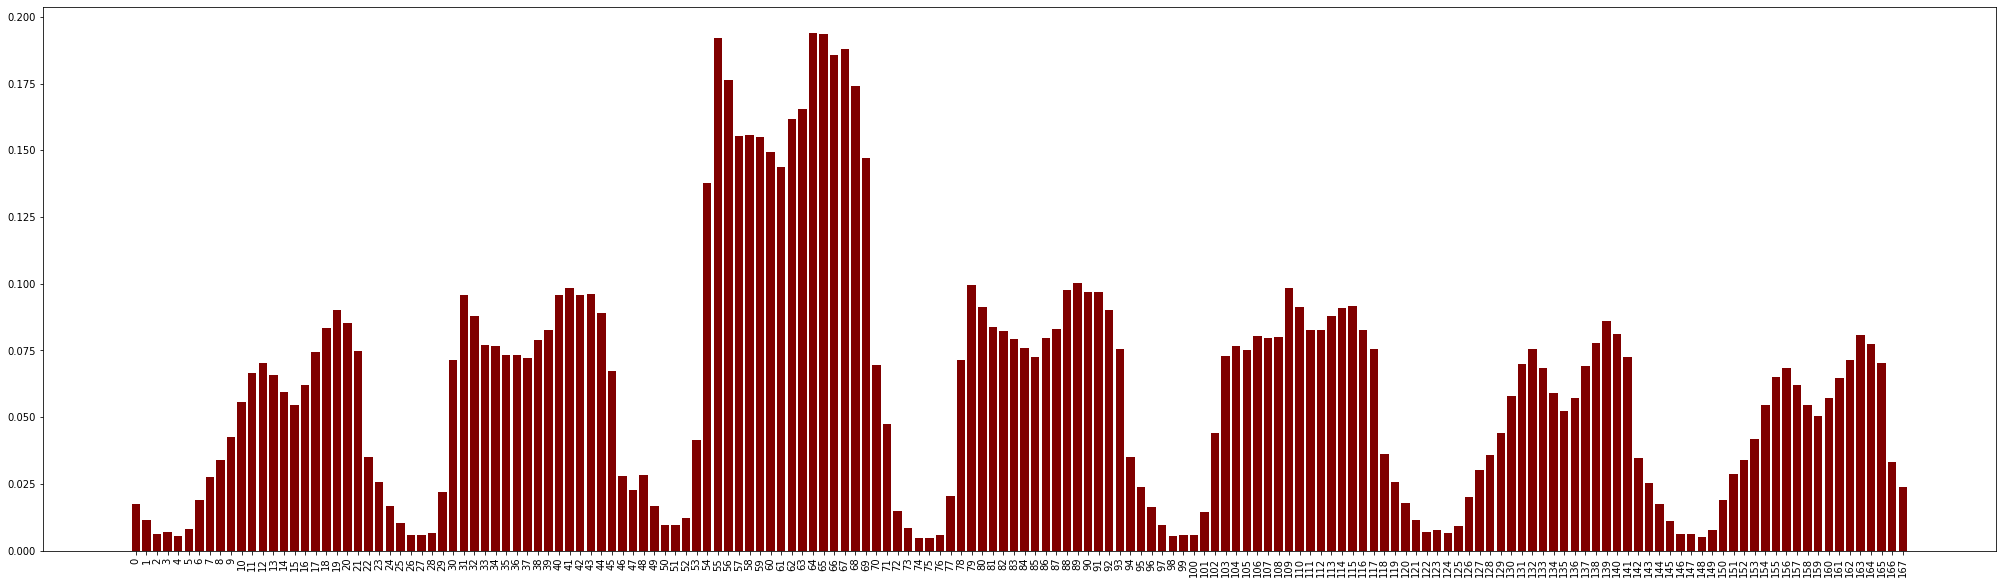

In [24]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (35, 10))
# print(len(lable_list))
# print(len(topics[:,topic]))
label_list = list(map(lambda x: str(x), range(24*7)))
plt.bar(label_list, times, color ='maroon',
width = 0.8)
plt.xticks(rotation='vertical',fontsize=10)
plt.show()